In [1]:
# import modules/libraries
import warnings 
warnings.simplefilter(action='ignore')
from entsoe import EntsoePandasClient
import pandas as pd
import json
import requests
from pandas import json_normalize
from bs4 import BeautifulSoup

import osmnx as ox
import pandas as pd
import numpy as np
import geopandas as gpd
import time
from datetime import datetime
from scipy import stats
import itertools
import os
import pickle
import geojson
from sqlalchemy import create_engine
import re
import sqlite3
from pathlib import Path
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import chardet
from scipy import spatial
from scipy.spatial import KDTree
from shapely import wkt

cwd = Path().resolve()

# visualisation
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib as mpl 
%matplotlib inline 
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

node
  [man_made=pipeline]
  ({{bbox}});
out;

In [2]:
client = EntsoePandasClient(api_key="2d80d663-6eb6-447f-b31b-9d5c6b41365a")


In [12]:
s = requests.Session()
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

def lng_tankers():
    df2 = pd.DataFrame()
    for i in range(1,40):
        try:
            url = f'https://www.vesselfinder.com/de/vessels?page={i}&type=604'
            r = requests.get(url, headers=header)
            r.raise_for_status()
            df = pd.read_html(r.text, extract_links='all')[0]
            df.rename(columns={df.columns[0]: 'imo'}, inplace=True)
            df['imo'] = df.apply(lambda x: x['imo'][1], axis=1)
            df['imo']= df['imo'].str.split("/").str[-1]
            
            
            df.rename(columns={df.columns[1]: 'ship'},inplace=True)
            df['ship'] = df.apply(lambda x: x['ship'][0], axis=1)
    
            df.rename(columns={df.columns[2]: 'build'},inplace=True)
            df['build'] = df.apply(lambda x: x['build'][0], axis=1)
            
            df.rename(columns={df.columns[3]: 'GT'},inplace=True)
            df['GT'] = df.apply(lambda x: x['GT'][0], axis=1)

            df.rename(columns={df.columns[4]: 'DWT'},inplace=True)
            df['DWT'] = df.apply(lambda x: x['DWT'][0], axis=1)
            
            df.rename(columns={df.columns[5]: 'size'},inplace=True)
            df['size'] = df.apply(lambda x: x['size'][0], axis=1)
            
            df[['ship', 'type']] = df["ship"].apply(lambda x: pd.Series(str(x).split("  LNG Tanker")))
            df['type'] = "LNG Tanker"
            
            df2 = df2.append(df, ignore_index=True)
            
        except Exception as e:
            print(e)
            break
    
    df2.to_csv('./data/lng_tankers.csv', index=False)
    return df2


def get_location(imo):
    try:
        hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}

        url = f"https://www.vesselfinder.com/en/vessels/VOS-TRAVELLER-IMO-{imo}"
        r = s.get(url, headers=header)
        r.raise_for_status()
        soup = BeautifulSoup(r.text)
        data = json.loads(soup.find("div", {"id": "djson"})['data-json'])
        print(data['ship_lat'], data['ship_lon'])
        time.sleep(0.1)
        return pd.Series([data['ship_lat'], data['ship_lon']])
    
    except Exception as e:
        print(e)
        input("change vpn")
        return pd.Series([np.nan, np.nan])

def get_vessels():
    # lng = lng_tankers()
    lng = pd.read_csv('./data/lng_tankers.csv', index_col=False)
    lng[['lat', 'lon']] = lng.apply(lambda x: get_location(x['imo']), axis=1)
    lng.to_csv('./data/lng_tankers_lat.csv', index=False)
    return df
# lng_vessesl = get_vessels()


https://github.com/EnergieID/entsoe-py/blob/master/entsoe/mappings.py

country codes and examples:
https://thesmartinsights.com/how-to-query-data-from-the-entso-e-transparency-platform-using-python/


In [3]:
start = pd.Timestamp('20221209', tz='Europe/Brussels')
end = pd.Timestamp('20221210', tz='Europe/Brussels')
country_code = 'AT'  # Belgium
country_code_from = 'FR'  # France
country_code_to = 'DE_LU' # Germany-Luxembourg
type_marketagreement_type = 'A01'
contract_marketagreement_type = 'A01'

data = {}


eu_list = ['AT', 'BE', 'BG','HR', 'CZ', 'DE_LU', 'DK', 'EE', 'FI', 'FR', 'GR', 'HU', 'IE', 'IT', 'LV',
          'NL']
for country in eu_list:
    try:
        s = client.query_day_ahead_prices(country, start=start,end=end)
        df = s.to_frame()
        df.rename(columns={df.columns[0]: 'price_mwh'},inplace=True)
        mean_price = df.price_mwh.mean()
        print(mean_price, country)
        #df.head(24)
        data[country] = mean_price
    except:
        print("problem in ", country)
    

411.07599999999996 AT
433.72159999999997 BE
336.0964 BG
359.14880000000005 HR
396.90600000000006 CZ
407.0996 DE_LU
problem in  DK
404.0900000000001 EE
403.52240000000006 FI
443.7228 FR
297.4228 GR
402.346 HU
problem in  IE
problem in  IT
404.0900000000001 LV
409.9275999999999 NL


In [4]:
data

{'AT': 411.07599999999996,
 'BE': 433.72159999999997,
 'BG': 336.0964,
 'HR': 359.14880000000005,
 'CZ': 396.90600000000006,
 'DE_LU': 407.0996,
 'EE': 404.0900000000001,
 'FI': 403.52240000000006,
 'FR': 443.7228,
 'GR': 297.4228,
 'HU': 402.346,
 'LV': 404.0900000000001,
 'NL': 409.9275999999999}

In [5]:
s = client.query_day_ahead_prices('IT_NORD', start=start,end=end)
df = s.to_frame()
df.rename(columns={df.columns[0]: 'price_mwh'},inplace=True)
mean_price = df.price_mwh.mean()
print(mean_price)
df.head(24)

419.38159999999993


,price_mwh
2022-12-09 00:00:00+01:00,336.70
2022-12-09 01:00:00+01:00,329.84
2022-12-09 02:00:00+01:00,318.48
2022-12-09 03:00:00+01:00,310.64
2022-12-09 04:00:00+01:00,309.28
2022-12-09 05:00:00+01:00,321.19
2022-12-09 06:00:00+01:00,363.43
2022-12-09 07:00:00+01:00,456.95
2022-12-09 08:00:00+01:00,477.25
2022-12-09 09:00:00+01:00,484.10


In [6]:
start = pd.Timestamp('20221204', tz='Europe/Brussels')
end = pd.Timestamp('20221205', tz='Europe/Brussels')
t =client.query_generation_per_plant(country_code, start=start,end=end, psr_type=None)
t.head()

,Abwinden-Asten,Altenwörth,Aschach,Block 07 Linz,DO3,FHKW Mellach,Freudenau,GDK-Mellach Linie 10,GDK-Mellach Linie 20,Gerlos,Greifenstein,Häusling,KW Riedersbach 2 G2,KW Theiß M3,KW Theiß M5,Kaprun-Hauptstufe,Kaprun-Oberstufe,Kaprun-Schwarzach,Kraftwerk Timelkam GUD,Lau GuD,Limberg II,Malta-Hauptstufe,Malta-Oberstufe,Mayrhofen,Melk,Ottensheim-Wilhering,Reisseck 2,Roßhag,Sim1_DT,Sim1_GT41,Sim1_GT42,Sim3_DT,Wallsee-Mitterkirchen,Ybbs-Persenbeug
,Hydro Run-of-river and poundage,Hydro Run-of-river and poundage,Hydro Run-of-river and poundage,Fossil Gas,Fossil Gas,Fossil Gas,Hydro Run-of-river and poundage,Fossil Gas,Fossil Gas,Hydro Water Reservoir,Hydro Run-of-river and poundage,Hydro Pumped Storage,Fossil Hard coal,Fossil Gas,Fossil Gas,Hydro Water Reservoir,Hydro Pumped Storage,Hydro Water Reservoir,Fossil Gas,Fossil Gas,Hydro Pumped Storage,Hydro Pumped Storage,Hydro Pumped Storage,Hydro Water Reservoir,Hydro Run-of-river and poundage,Hydro Run-of-river and poundage,Hydro Pumped Storage,Hydro Pumped Storage,Fossil Gas,Fossil Gas,Fossil Gas,Fossil Gas,Hydro Run-of-river and poundage,Hydro Run-of-river and poundage
newlevel,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated,Actual Aggregated
2022-12-04 00:00:00+01:00,86.0,160.0,119.0,107.0,304.0,0.0,91.0,0.0,0.0,1.0,143.0,0.0,0.0,0.0,0.0,31.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,89.0,0.0,0.0,193.0,255.0,255.0,0.0,111.0,109.0
2022-12-04 01:00:00+01:00,84.0,158.0,119.0,100.0,207.0,0.0,90.0,0.0,0.0,0.0,142.0,0.0,0.0,0.0,0.0,30.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,87.0,0.0,0.0,128.0,167.0,167.0,0.0,109.0,109.0
2022-12-04 02:00:00+01:00,84.0,156.0,121.0,100.0,182.0,0.0,91.0,0.0,0.0,0.0,140.0,0.0,0.0,0.0,0.0,28.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,90.0,0.0,0.0,114.0,147.0,147.0,0.0,109.0,108.0
2022-12-04 03:00:00+01:00,84.0,156.0,121.0,104.0,182.0,0.0,91.0,0.0,0.0,0.0,140.0,0.0,0.0,0.0,0.0,18.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,108.0,93.0,0.0,0.0,90.0,113.0,113.0,0.0,111.0,107.0
2022-12-04 04:00:00+01:00,86.0,154.0,124.0,105.0,183.0,0.0,89.0,0.0,0.0,0.0,139.0,0.0,0.0,0.0,0.0,34.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,94.0,0.0,0.0,90.0,113.0,113.0,0.0,110.0,108.0


### Standorte

https://wiki.openmod-initiative.org/wiki/SciGRID_gas

maybe
http://users.dimi.uniud.it/~massimo.franceschet/ns/syllabus/make/gas/gas.html

https://github.com/mihai-craita/countries_center_box

In [117]:
def get_centroid():
    """ Get centroid coordinates for all countries
        source: https://github.com/mihai-craita/countries_center_box
    """
    url = 'https://raw.githubusercontent.com/mihai-craita/countries_center_box/master/countries.json'
    r = requests.get(url)
    data = json.loads(r.text)
    df = pd.DataFrame.from_dict(data)
    return df

In [118]:
def get_lat_long(point):
    """ get latitude and longitude coordinate from POINT geometry """
    try:
        return pd.Series([point.x, point.y])
    except:
        print("error")
        pass

def get_gie_data_V0():
    """ Read Excel data from gas infrastructure operators of Europe (GIE).
        source: https://www.gie.eu/transparency/databases/
                https://www.gas.scigrid.de/posts/2010-Okt-03_gie_raw.html
                
        just temporary -> later on use the exel file from GIE website
            #f = open('./data/GIE_Raw/data/GIE_LNGs.geojson')
    data = json.load(f)
    f.close()
    data = json.loads(data)
    df = pd.DataFrame.from_dict(data['features'][0])
    df = pd.read_json('./data/GIE_Raw/data/GIE_LNGs.geojson', orient='columns')
    """
    df = gpd.read_file('./data/GIE_Raw/data/GIE_LNGs.geojson')
    df[['lon', 'lat']] = df.apply(lambda x: get_lat_long(x['geometry']), axis=1)
    df.drop(columns=['tags', 'uncertainty', 'method', 'geometry', 'param'], inplace=True)
    return df

# GIE_LNGs = get_gie_data_V0()
# GIE_LNGs.tail(200)

In [10]:
def add_trace(fig, df, col="#76b5c5", size=12):
    template=f"<br>Name: {df['Name']}</b><extra></extra>"
    fig.add_scattermapbox(
        lat=[df['lat']], lon=[df['lon']], mode='markers',
        hovertemplate= template,
        marker_size=size, marker_color=col,
        line=dict(width=12),opacity= 0.8, hoverinfo='none',
        showlegend=False,)


def draw_lng_terminals_V0(df):
    fig = go.Figure()
    
    for index, row in df.iterrows():
        add_trace(fig, row, col="#76b5c5", size=13)
    
    fig.update_layout(mapbox_style="light", mapbox_accesstoken="pk.eyJ1IjoiYXJlYnVyZyIsImEiOiJjbDZkZzdhOXAwNTk5M2ZteDdkY3lvd2FsIn0.c4hsFv69HozIVHq7ItrTzg",
                      mapbox_zoom=3,
                     mapbox_center={"lat": 47.809490, "lon": 13.055010})
    fig.update_layout(font=dict(family="Helvetica"), legend={"title": "Select category"})
    fig.update_layout(margin={"r": 0, "t": 40, "l": 0, "b": 0}, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(title_text = 'All global LNG Ports')
    fig.show()

In [139]:
def get_gie_data_V1():
    """ Read Excel data from gas infrastructure operators of Europe (GIE).
        source: http://globalenergyobservatory.org/list.php?db=Transmission&type=LNG_Ports

    """
    df = pd.read_html('http://globalenergyobservatory.org/list.php?db=Transmission&type=LNG_Ports',
                      header=0, displayed_only=False, attrs = {'id': 'list'}, extract_links='all')[0]
    
    df.rename(columns={df.columns[0]:'Name', df.columns[1]:'Capacity', df.columns[2]:'Country',
                       df.columns[3]:'State'}, inplace=True)
    return df


def get_lat_long_V1(name):
    """ make request to separate link and extract lat and longitude. """
    url = f"http://globalenergyobservatory.org/{name}"
    df_tmp = pd.read_html(url, header=0, displayed_only=False)[0]
    for txt in df_tmp.columns:
        if 'Lat' in txt:
            res = [float(i) for i in re.findall(r"[-+]?(?:\d*\.*\d+)", txt) if not i.isdecimal()]
            try:
                return pd.Series([res[0], res[1]])
            except:
                pass

def radius_around_port(lat, lon, radius_in_meter):
    radius = gpd.GeoDataFrame({'ship': f'test', 'geometry': [Point(lon, lat)]}, crs='EPSG:4326')
    radius = radius.to_crs(epsg=7855).buffer(radius_in_meter).to_crs(epsg=4326)
    boundary_geojson = gpd.GeoSeries(radius)
    region = boundary_geojson.geometry.unary_union
    return region


def lng_ports():
    """ main function to scrape all lng ports """
    df = get_gie_data_V1()
    df[['lat', 'lon']] = df.apply(lambda x: get_lat_long_V1(x['Name'][1]), axis=1)
    df['Name'] = df.apply(lambda x: x['Name'][0], axis=1)
    df['Capacity'] = df.apply(lambda x: x['Capacity'][0], axis=1)
    df['Country'] = df.apply(lambda x: x['Country'][0], axis=1)
    df['State'] = df.apply(lambda x: x['State'][0], axis=1)
    df.to_csv('./data/GIE_LNGs_V1.csv', index=False)
    return df


def get_line(poly):
    try:
        #ls = shapely.geometry.LineString(df) # shapely.geometry.LineString(shapely.ops.unary_union(df).exterior.coords)
        b = poly.boundary.coords
        ls = shapely.geometry.LineString(b)
            
        #linestrings = [LineString(b[k:k+2]) for k in range(len(b) - 1)]
        #print([list(ls.coords) for ls in linestrings])
        lats, lons = ls.coords.xy
        return pd.Series([lats, lons])
    except Exception as e:
        print(e)
        return pd.Series([np.nan, np.nan])
    
# draw_lng_terminals_V0(GIE_LNGs_V1)
from shapely.geometry import Polygon, LineString

p = pd.read_csv('./data/GIE_LNGs_V1.csv', index_col=False) # lng_ports()
#p = p.iloc[10:50,:]
p['bubble'] = ports.apply(lambda x: radius_around_port(x['lat'], x['lon'], radius_in_meter=60000), axis=1)
#p=p.iloc[10:30,:]
p[['lats','lons']] = ports.apply(lambda x: get_line(x['bubble']), axis=1)
ports = p.copy()
ports.head(2)

ERROR:shapely.geos:IllegalArgumentException: Operation not supported by GeometryCollection

ERROR:shapely.geos:IllegalArgumentException: Operation not supported by GeometryCollection

ERROR:shapely.geos:IllegalArgumentException: Operation not supported by GeometryCollection

ERROR:shapely.geos:IllegalArgumentException: Operation not supported by GeometryCollection



No Shapely geometry can be created from null value
No Shapely geometry can be created from null value
No Shapely geometry can be created from null value
No Shapely geometry can be created from null value


,Name,Capacity,Country,State,lat,lon,bubble,lats,lons
0,Arzew GNL 3Z LNG Plant Algeria,4700000.0,Algeria,Oran,35.80452,-0.240970,POLYGON ((-0.8014957489073835 35.9749035641715...,"[-0.8014957489073835, -0.7783330711060338, -0....","[35.97490356417152, 36.01892728818363, 36.0608..."
1,Arzew-GL1Z LNG Plant Algeria,7900000.0,Algeria,Oran,35.81237,-0.266489,POLYGON ((-0.827229951099672 35.98266547090419...,"[-0.827229951099672, -0.8040750265444842, -0.7...","[35.98266547090419, 36.02670230312995, 36.0686..."


In [132]:
lng = pd.read_csv('./data/lng_tankers_lat.csv', index_col=False)
lng.sort_values(by='DWT', ascending=False, inplace=True)

### References Konkurrenz
https://lng.team/#prices
https://medium.com/analytics-vidhya/how-to-create-a-simple-web-app-for-a-vessels-eta-api-using-python-db485182a8c2


In [78]:
ports = p.copy()
ports.head()
def check_if_coord_in_poly(region, lon, lat):
    """
    Check if a coordinate (lat,long) is within a given polygon
    Used to check for an address in vienna geometry
    source: https://stackoverflow.com/questions/48097742/geopandas-point-in-polygon
    Return: True if Point within Polygon
    
    source: https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
    
    """
    """
    _pnts = [Point(lon, lat)]
    poly = gpd.GeoSeries({'within': region})
    pnts = gpd.GeoDataFrame(geometry=_pnts, index=['Point to check'], crs=get_local_crs(lon, lat))
    pnts = pnts.assign(**{key: pnts.within(geom) for key, geom in poly.items()})
    return pnts['within'].item()
    """
    point = Point(lon, lat)
    return region.contains(point)
    
for index, row in ports.iterrows():
    lng['close_to_harbor'] = lng.apply(lambda x: check_if_coord_in_poly(row['bubble'], x['lon'], x['lat']), axis=1)

#lng['vessel'] = lng.apply(lambda x: harbor(x['ship'], x['lat'], x['lon']), axis=1)
lng.head()

,imo,ship,build,GT,DWT,size,type,lat,lon,vessel,close_to_harbor
0,9388819,LIJMILIYA,2009,168189,155159,345 / 55,LNG Tanker,6.69627,77.42957,False,False
1,9372743,AL GHUWAIRIYA,2008,168189,154940,345 / 55,LNG Tanker,6.42555,95.11727,False,False
2,9388821,AL SAMRIYA,2009,168189,154900,345 / 55,LNG Tanker,39.92342,-10.14878,False,False
3,9388833,BU SAMRA,2008,163922,130442,345 / 54,LNG Tanker,6.25460,95.26184,False,False
4,9397315,AL MAFYAR,2009,163922,130441,345 / 54,LNG Tanker,1.39792,104.46966,False,False


In [135]:
def add_ship(fig, df, col="#76b5c5", size=12):
    try:
        template=f"<br>Name: {df['imo']}</b><extra></extra>"
        fig.add_scattermapbox(
            lat=[df['lat']], lon=[df['lon']], mode='markers',
            hovertemplate=template,
            marker_size=size, marker_color=col,
            line=dict(width=6),opacity= 0.4, hoverinfo='none',
            showlegend=False,)
    
    except Exception as e:
        print(e)

def add_radius(fig, df):
    try:
        radius_in_meter = 10000
        fig.add_trace(go.Scattermapbox(
                mode="lines",
                lon=list(df['lats']),
                lat=list(df['lons']),
                name=f"{radius_in_meter} m radius",
                hoverinfo='skip',
                showlegend=False,
                marker={'size': 15, 'color': 'red', 'opacity': 0.2}))
    except Exception as e:
        pass

def add_ports(fig, df, col="#bbb5c5", symbol="harbor", size=12):
    try:
        if symbol == "harbor":
            fig.add_scattermapbox(
            name='Home', lat=df['lat'].tolist(), lon=df['lon'].tolist(),
            mode='markers+text',
            marker=dict(size=size, color=col),
            text=df['Name'].tolist(),
            textposition="bottom center",
            hoverinfo='text',
            textfont=dict(color='black', size=10),
            showlegend=False,)
                
        else:
            #template=f"<br>Name: {df['imo']}</b><extra></extra>"
            fig.add_scattermapbox(
                name='Home',
                lat=df['lat'].tolist(), lon=df['lon'].tolist(),
                mode='markers',
                #hovertemplate=template,
                #marker_size=size, 
                #marker_color=col,
                marker=dict(size=size, symbol=symbol, color=col),
                #line=dict(width=6),
                #if symbol == "harbor":
                #    text=df['Name'].tolist(),
               #    textposition="bottom center",
                #    hoverinfo='text',
               #     textfont=dict(color='black', size=10),

                showlegend=False,)

    except Exception as e:
        print(e)

def vessel(df, ports):
    fig = go.Figure()
    
    
    add_ports(fig, ports, col="#76b5c5", symbol="harbor", size=16)
    add_ports(fig, df, col="#be4d25", symbol="marker", size=10)   
    
        
    for index, row in ports.iterrows():
        add_radius(fig, row)
    
    fig.update_layout(mapbox_style="light", mapbox_accesstoken="pk.eyJ1IjoiYXJlYnVyZyIsImEiOiJjbDZkZzdhOXAwNTk5M2ZteDdkY3lvd2FsIn0.c4hsFv69HozIVHq7ItrTzg",
                      mapbox_zoom=3,
                     mapbox_center={"lat": 47.809490, "lon": 13.055010})
    fig.update_layout(font=dict(family="Helvetica"), legend={"title": "Select category"})
    fig.update_layout(margin={"r": 0, "t": 40, "l": 0, "b": 0}, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(title_text = 'All global LNG Ports')
    fig.show()


vessel(lng, ports)

In [30]:
from pathlib import Path
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

gdf = gpd.GeoDataFrame({'address': 'Burggasse 2, Wien', 'geometry': [Point(16.363449, 48.210033)]}, crs='EPSG:4326')
gdf.head()

,address,geometry
0,"Burggasse 2, Wien",POINT (16.36345 48.21003)


In [35]:
radius = gdf.copy()
radius_in_meter = 1000
radius = radius.to_crs(epsg=7855).buffer(radius_in_meter).to_crs(epsg=4326)
radius.head()
import geopandas as gpd

In [39]:
shapely_polygon= shapely.geometry.Polygon([(0, 0), (0, 1), (1, 0)])
t = gpd.GeoSeries(radius).to_json()
t

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[16.354686099759732, 48.21512588471708], [16.355475214940938, 48.21567547448242], [16.356341155407307, 48.21617071382693], [16.35727557871914, 48.21660683077591], [16.358269481740223, 48.21697962312017], [16.359313287501337, 48.21728549896897], [16.360396937629314, 48.21752151140688], [16.361509989443782, 48.21768538691932], [16.362641716776988, 48.217775547309934], [16.363781213536882, 48.217791124899094], [16.3649174990057, 48.21773197085657], [16.366039623849375, 48.21759865658904], [16.36713677580741, 48.217392468171006], [16.368198384035285, 48.21711539387501], [16.369214221087503, 48.216770104925196], [16.370174501550522, 48.216359929662076], [16.37106997637225, 48.21588882137317], [16.371892021974478, 48.215361320101934], [16.372632723290117, 48.21478250880939], [16.373284949924365, 48.214157964313], [16.373842424710688, 48.21349370348113]

In [33]:
import shapely.ops
import shapely.geometry
ls = shapely.geometry.LineString(shapely.ops.unary_union(radius).exterior.coords)
ls
lats, lons = ls.coords.xy
lats

array('d', [16.354686099759732, 16.355475214940938, 16.356341155407307, 16.35727557871914, 16.358269481740223, 16.359313287501337, 16.360396937629314, 16.361509989443782, 16.362641716776988, 16.363781213536882, 16.3649174990057, 16.366039623849375, 16.36713677580741, 16.368198384035285, 16.369214221087503, 16.370174501550522, 16.37106997637225, 16.371892021974478, 16.372632723290117, 16.373284949924365, 16.373842424710688, 16.37429978400411, 16.374652629138495, 16.37489756855883, 16.375032250232913, 16.37505538403825, 16.37496675392048, 16.374767219714975, 16.374458708625085, 16.37404419644771, 16.373527678735716, 16.37291413218128, 16.37220946659776, 16.371420467965688, 16.370554733093048, 16.36962059651868, 16.36862705035967, 16.367583657871258, 16.366500461544668, 16.36538788662102, 16.36425664094137, 16.363117612088164, 16.36198176279767, 16.360860025641955, 16.35976319798284, 16.35870183820219, 16.357686164197926, 16.35672595511762, 16.35583045727023, 16.355008295118814, 16.354267

In [74]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

def get_region():
    """  """
    boundary_geojson = gpd.read_file(os.path.join(Path(cwd), 'data', 'geojson', 'vienna.geojson'))
    boundary_geojson.drop(columns=['cartodb_id', 'created_at', 'updated_at'], inplace=True)
    region = boundary_geojson.geometry.unary_union
    return region
    
def get_local_crs(y, x):
    """ get local crs """
    x = ox.utils_geo.bbox_from_point((y, x), dist=500, project_utm=True, return_crs=True)
    return x[-1]




#if not check_if_coord_in_poly(region, dfi['longitude'].item(), dfi['latitude'].item()):

In [70]:
ports.head()

,Name,Capacity,Country,State,lat,lon,bubble
0,Arzew GNL 3Z LNG Plant Algeria,4700000.0,Algeria,Oran,35.80452,-0.240970,POLYGON ((-1.177790606652809 36.08740692474428...
1,Arzew-GL1Z LNG Plant Algeria,7900000.0,Algeria,Oran,35.81237,-0.266489,POLYGON ((-1.2036679182306889 36.0951083494192...
2,Arzew-GL2Z LNG Plant Algeria,8200000.0,Algeria,Oran,35.81000,-0.259678,POLYGON ((-1.1967580142129641 36.0927761688026...
3,Skikda Algeria LNG Plant Algeria,7850000.0,Algeria,Skikda,36.87790,6.941500,POLYGON ((6.074453816618588 37.223697358250334...
4,Angola LNG Plant Angola,5200000.0,Angola,Zaire,-6.11957,12.335960,POLYGON ((11.699137923361747 -6.18839170390859...


In [90]:
geome = ports['bubble'].iloc[0]
ls = shapely.geometry.LineString(shapely.ops.unary_union(geome).exterior.coords)
lats, lons = ls.coords.xy
lats

array('d', [-1.177790606652809, -1.139352229309787, -1.0920616647148504, -1.0363694394426914, -0.9728149940656721, -0.9020214402808732, -0.8246891904428781, -0.7415885298964898, -0.6535512265994129, -0.5614612951688752, -0.46624505273294353, -0.3688606209319539, -0.2702870413152002, -0.17151317961255624, -0.07352659752650181, 0.022697431355707492, 0.11620659208249566, 0.20608172773682587, 0.2914464261968971, 0.37147587214125555, 0.44540486400965573, 0.5125349188947281, 0.5722404120136512, 0.6239737205290374, 0.6672693631802104, 0.7017471467213733, 0.7271143469875935, 0.7431669661464898, 0.7497901181632687, 0.7469576017005735, 0.7347307237431882, 0.7132564384631577, 0.6827648646048053, 0.6435662414218499, 0.5960473784302137, 0.5406676484470441, 0.4779545670546029, 0.40849899520811894, 0.3329499955975173, 0.25200936792324713, 0.16642588372704253, 0.07698923804169176, -0.01547626696242536, -0.11011829188248184, -0.20606326842277714, -0.30242342903272545, -0.3983040374085765, -0.4928107949

In [73]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point(0.5, 2.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
print(polygon.contains(point))

False


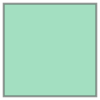

In [86]:
polygon
